In [1]:
# setup
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import requests
import calendar
import geopandas as gpd
import os.path as os
import scipy.stats
import seaborn.palettes
import seaborn.utils
import sys
from census import Census
from us import states
from sklearn.metrics import precision_recall_fscore_support
import config

root= r"C:/Users/Jennah/Desktop/Code/machine-learning-final"
inp= os.join(root, "data", "3_clean")
interm= os.join(root, "data", "2_intermediate")

plots= os.join(root, "code", "plots")

In [2]:
from pydrive.auth import GoogleAuth

gauth = GoogleAuth()
gauth.LocalWebserverAuth() # Creates local webserver and auto handles authentication.

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=570719947456-53haph7mjc317oel1ujh0kmjbfd499jf.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


In [3]:
# files in clean data google drive
from pydrive.drive import GoogleDrive
drive = GoogleDrive(gauth)
fileList = drive.ListFile({'q': "'1jxSI_nq32-W9kPHKvQkzuNGJ5aIBD2j2' in parents and trashed=false"}).GetList()
for file in fileList:
  print('Title: %s, ID: %s' % (file['title'], file['id']))
  # Get the folder ID that you want
  if(file['title'] == "To Share"):
      fileID = file['id']

Title: analysis_bbl.csv, ID: 1yYX-ROr1c7fzcQiG6NZ1sh7Ko5gqr_4G
Title: borobox_convex_hull.geojson, ID: 1SzBNj3Ba-v9MEwuCkZT9e9iAwVYUqx8r
Title: analysis_bbl_noacs.csv, ID: 1h-tDpBSslfzqzsJe1ny_ujDnr68RKry3
Title: analysis_box.csv, ID: 1Vzjvta98IG9Hg4SfAGcd8JD8FaF3IXwy


## Load building level analysis file

In [4]:
df_bbl = drive.CreateFile({'id': '1yYX-ROr1c7fzcQiG6NZ1sh7Ko5gqr_4G'})
df_bbl.GetContentFile('analysis_bbl.csv')  

df_bbl= pd.read_csv('analysis_bbl.csv').drop(["Unnamed: 0"], axis = 1)
df_bbl.head()

,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,yearbuilt,...,pctnhother,pctnhtwoplus,pctownerocch,pctrentocch,crowding,crowdingrenter,bbl,boroct2010,vacate_ind,borough
0,2013.0,5555.0,1.0,4.0,6.0,6.0,345150.0,1317150.0,0.0,1899.0,...,1.483051,2.106874,32.879925,67.120075,2.532833,3.773585,1012090027,1018100,0.0,MN
1,2517.0,6895.0,1.0,4.0,10.0,10.0,427500.0,1244700.0,0.0,1891.0,...,1.483051,2.106874,32.879925,67.120075,2.532833,3.773585,1012090028,1018100,0.0,MN
2,10570.0,127289.0,1.0,17.0,69.0,69.0,2616300.0,12195900.0,136178.0,1930.0,...,1.483051,2.106874,32.879925,67.120075,2.532833,3.773585,1012090037,1018100,0.0,MN
3,3926.0,20358.0,1.0,6.0,25.0,25.0,490500.0,1929600.0,92325.0,1961.0,...,1.483051,2.106874,32.879925,67.120075,2.532833,3.773585,1012090049,1018100,0.0,MN
4,5035.0,21258.0,1.0,6.0,12.0,12.0,585000.0,1414350.0,15640.0,1905.0,...,1.483051,2.106874,32.879925,67.120075,2.532833,3.773585,1012090051,1018100,0.0,MN


In [7]:
assert df_bbl["bbl"].isna().sum() == 0
assert df_bbl["holc_D"].isna().sum() == 0

# (1) Decision Trees and Random Forest Models

In [6]:
assert df_bbl.loc[:, "vacate_ind"].isna().sum() == 0

In [8]:
print(df_bbl.columns)
df_bbl.describe()

Index(['lotarea', 'bldgarea', 'numbldgs', 'numfloors', 'unitsres',
       'unitstotal', 'assessland', 'assesstot', 'exempttot', 'yearbuilt',
       'holc_AB', 'holc_CD', 'holc_D', 'tot_hpd_vio', 'hpd_fire_vio',
       'hpd_b_c_vio', 'viol_count_per_unit', 'hpd_fire_vio_per_unit',
       'hpd_b_c_vio_per_unit', 'AL', 'NB', 'average_energy_usage',
       'average_energy_usage_mi', 'totpop', 'popdens', 'areasqmile', 'males',
       'females', 'pop18under', 'pop18_34', 'pop35_64', 'pop65plus',
       'pophispanic', 'popnhwhite', 'popnhblack', 'popnhaian', 'popnhasian',
       'popnhhawainpi', 'popnhother', 'popnhtwoplus', 'housing',
       'housingoccupied', 'renterhousing', 'oc_halfless', 'oc_half_1',
       'oc_1_onehalf', 'oc_onehalf_2', 'oc_2plus', 'roc_halfless',
       'roc_half_1', 'roc_1_onehalf', 'roc_onehalf_2', 'roc_2plus',
       'medianyearbuilt', 'mediangrossrent', 'medianhhincome', 'gini', 'year',
       'pct18under', 'pct18_34', 'pct35_64', 'pct65plus', 'pcthispanic',
     

,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,yearbuilt,...,pctnhhawainpi,pctnhother,pctnhtwoplus,pctownerocch,pctrentocch,crowding,crowdingrenter,bbl,boroct2010,vacate_ind
count,7.650260e+05,7.650260e+05,765026.000000,765026.000000,765026.000000,765026.000000,7.650260e+05,7.650260e+05,7.650260e+05,765026.000000,...,765026.000000,765026.000000,765026.000000,765026.000000,765026.000000,765026.000000,765026.000000,7.650260e+05,7.650260e+05,765026.000000
mean,3.812014e+03,5.051030e+03,1.324975,2.443933,4.689669,4.894059,5.407344e+04,2.821186e+05,5.387875e+04,1938.547234,...,0.033562,1.119457,1.962135,50.197532,49.802468,8.170173,10.205338,3.548735e+09,3.541768e+06,0.003404
std,2.318736e+04,3.520154e+04,2.726640,1.676083,42.058995,47.000007,5.127009e+05,2.549800e+06,1.355497e+06,68.722810,...,0.269543,3.038141,2.060742,24.959007,24.959007,6.977816,9.218895,1.003515e+09,9.994487e+05,0.058243
min,2.300000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000070e+09,1.000201e+06,0.000000
25%,2.000000e+03,1.440000e+03,1.000000,2.000000,1.000000,1.000000,1.020000e+04,3.786000e+04,0.000000e+00,1920.000000,...,0.000000,0.000000,0.490998,29.103943,27.593699,3.289474,3.183024,3.036730e+09,3.030100e+06,0.000000
50%,2.500000e+03,2.020000e+03,1.000000,2.000000,2.000000,2.000000,1.368000e+04,5.172000e+04,0.000000e+00,1931.000000,...,0.000000,0.000000,1.404125,50.627615,49.372385,6.207928,8.142494,4.012680e+09,4.010200e+06,0.000000
75%,4.000000e+03,2.923000e+03,2.000000,2.750000,2.000000,2.000000,1.986000e+04,8.304000e+04,1.440000e+03,1960.000000,...,0.000000,0.778210,2.694064,72.406301,70.896057,11.000000,14.855072,4.107290e+09,4.092200e+06,0.000000
max,1.225343e+07,1.354011e+07,1807.000000,98.000000,19201.000000,19203.000000,1.345064e+08,6.899244e+08,4.435560e+08,2021.000000,...,7.191448,31.090573,20.276498,100.000000,100.000000,100.000000,100.000000,5.080500e+09,5.032300e+06,1.000000


In [9]:
df_bbl= pd.get_dummies(df_bbl, columns=["borough"])
borocols= ["borough_" + x for x in ["BK", "BX", "MN", "QN", "SI"]]

In [10]:
# define predictors
df_bbl.columns
predictors = ["lotarea", "bldgarea", "numbldgs", "numfloors", "unitsres", "unitstotal", "assessland",
             "assesstot", "exempttot", "yearbuilt", "holc_AB", "holc_CD", "holc_D",
             "tot_hpd_vio", "hpd_fire_vio", "hpd_b_c_vio",
             "viol_count_per_unit", "hpd_fire_vio_per_unit", "hpd_b_c_vio_per_unit",
             "AL", "NB", "average_energy_usage", "average_energy_usage_mi"]
predictors_acs= df_bbl.columns[df_bbl.columns.get_loc("totpop"):df_bbl.columns.get_loc("crowdingrenter") + 1].tolist()
predictors_full= predictors + predictors_acs
predictors_full;

In [11]:
outcomes= ["vacate_ind"]
df_bbl[outcomes].head()

# very small percentage of the data has had a fire
df_bbl[outcomes[0]].mean()

0.003403805883721599

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

X = df_bbl.loc[:, predictors_full].fillna(0)
y = df_bbl.loc[:, "vacate_ind"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=999)

dt = DecisionTreeClassifier(max_depth=10)
dt.fit(X_train, y_train)
y_predict = dt.predict(X_test)

# accuracy is very high, but that is bc most are 0s!
accuracy= (y_predict == y_test).value_counts(normalize=True)[True]
accuracy

0.9962615682242013

__Area under the curve__

In [15]:
dt=DecisionTreeClassifier(random_state = 99)
dt.fit(X_train,y_train)
# predict_proba predicts the probability of each class rather than just the most likely class
pred=dt.predict_proba(X_test)[:,1] # predicted probability of y = 1
roc_auc_score(np.array(y_test),pred)

0.56441374489671

In [15]:
# vs. random chance (only slightly better)
pred=np.random.random(len(X_test))
roc_auc_score(np.array(y_test.apply(int)),pred)

0.5127370672040699

## Tuning

In [16]:
from sklearn.model_selection import GridSearchCV
# This time we'll use max_depth to control the complexity of the tree, still using the same train/test split as above,
# and optimize the parameter value using GridSearchCV.
param_grid = {'max_depth':range(1,20)}
dt=DecisionTreeClassifier()
gr=GridSearchCV(dt,param_grid=param_grid, scoring='roc_auc')
rs=gr.fit(X_train,y_train)
print(rs.best_params_)
print(roc_auc_score(np.array(y_test),rs.predict_proba(X_test)[:,1]))

{'max_depth': 4}
0.9727891258700889


In [17]:
dt=DecisionTreeClassifier(max_depth = rs.best_params_['max_depth'], random_state= 99)
dt.fit(X_train,y_train)
# predict_proba predicts the probability of each class rather than just the most likely class
pred=dt.predict_proba(X_test)[:,1] # predicted probability of y = 1
roc_auc_score(np.array(y_test),pred)
## look at precision and recall rates
precision_recall_fscore_support(y_test, pred > 0.5)

(array([0.99668372, 0.67647059]),
 array([0.99995191, 0.02933673]),
 array([0.99831514, 0.05623472]),
 array([228724,    784], dtype=int64))

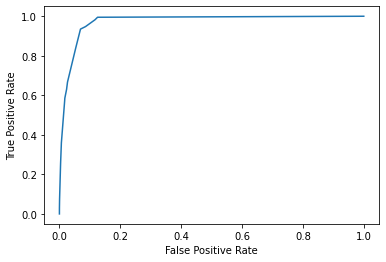

In [18]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

fpr, tpr, _ = roc_curve(y_test, pred, pos_label=1)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

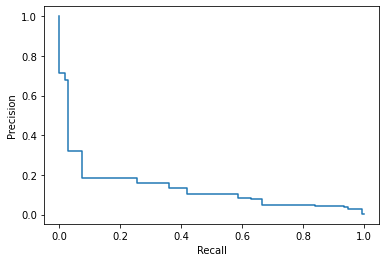

In [19]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

prec, recall, _ = precision_recall_curve(y_test, pred, pos_label= 1)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

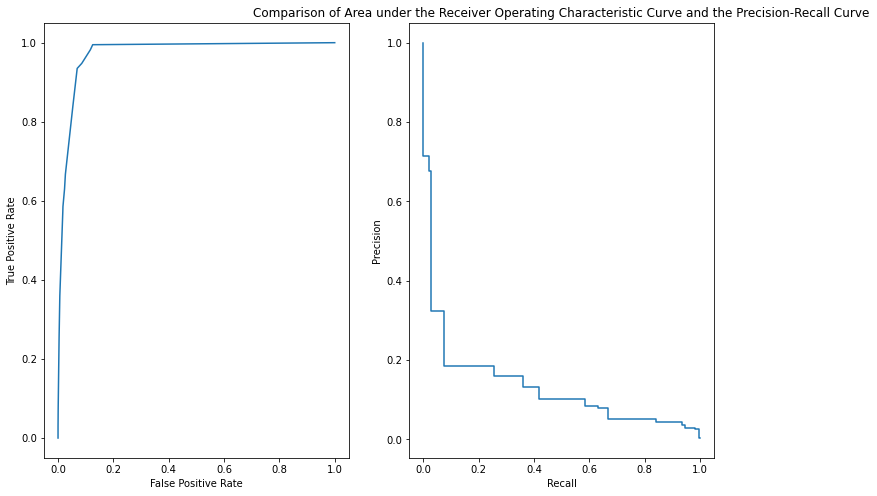

In [20]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.title("Comparison of Area under the Receiver Operating Characteristic Curve and the Precision-Recall Curve")
plt.show()
fig.savefig(os.join(plots, 'auc_precision_recall.png'))

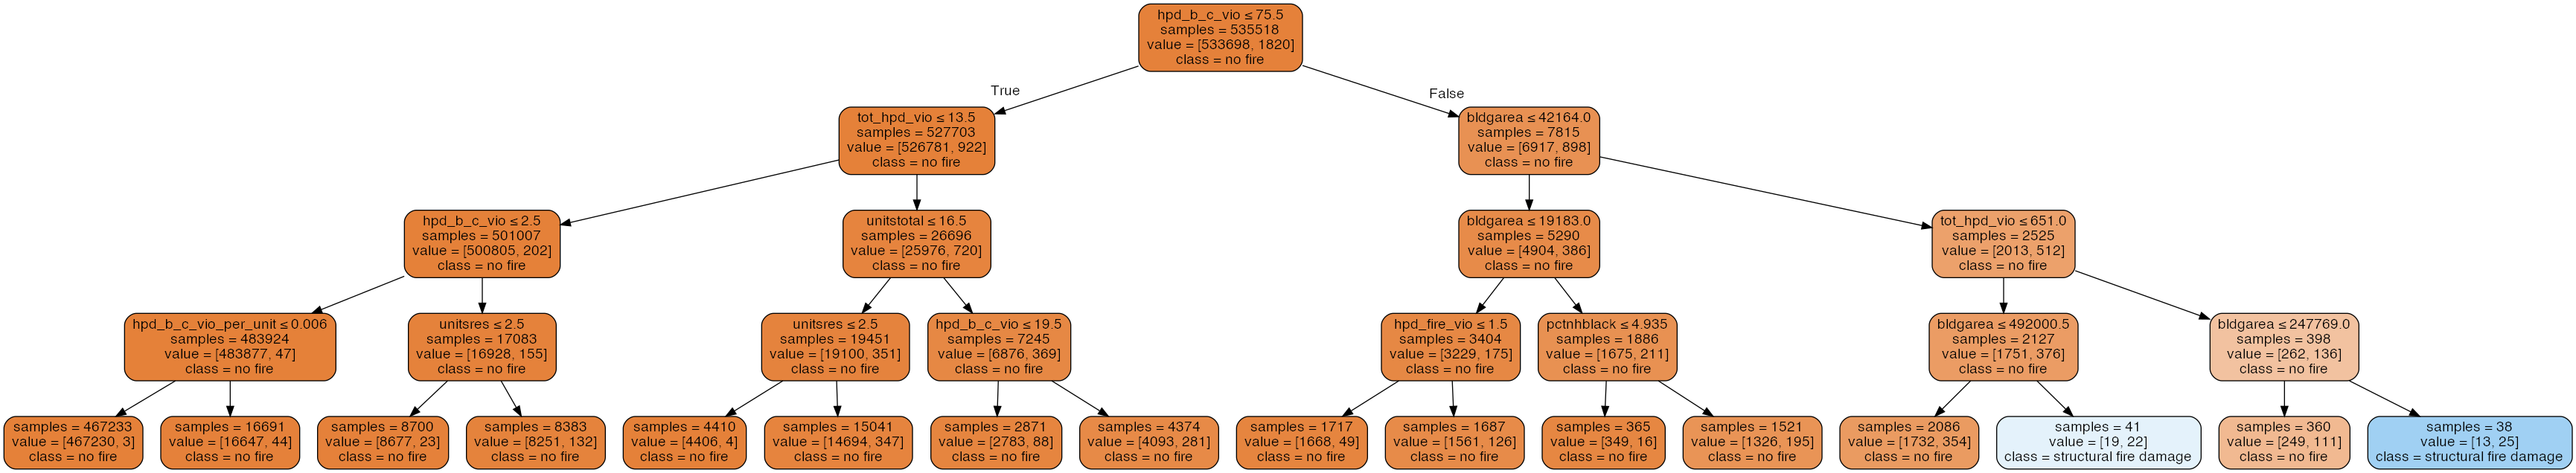

In [27]:
from sklearn import tree
from IPython.display import Image  
import pydotplus

# visualize the tree
dt = DecisionTreeClassifier(max_depth= rs.best_params_['max_depth'])
dt.fit(X_train, y_train)

thestring = tree.export_graphviz(dt, out_file=None,  
                         feature_names=X_train.columns.values, 
                         class_names=['no fire','structural fire damage'],  
                         filled=True, rounded=True,  
                         special_characters=True,impurity=False).replace(" ;\n}", " ;}")
graph = pydotplus.graph_from_dot_data(thestring);
graph.write_png(os.join(plots,'num_fire_ev_dt_bbl.png'))
Image(graph.create_png())

## Feature Importance

In [17]:
dt = DecisionTreeClassifier(max_depth= 4) #rs.best_params_['max_depth'])
dt.fit(X_train, y_train)
Feature_importance=pd.DataFrame([list(X_train.columns),list(dt.feature_importances_)]).T
Feature_importance.columns=["variables","importance"]

# list the top 10 most important features in order
ft= Feature_importance.sort_values(by="importance",ascending=False).iloc[:10,:]
ft.to_csv(os.join(interm, 'feature_importance_bbl.csv'))
ft

,variables,importance
15,hpd_b_c_vio,0.554119
1,bldgarea,0.233007
13,tot_hpd_vio,0.146877
5,unitstotal,0.031046
4,unitsres,0.013095
64,pctnhblack,0.011394
14,hpd_fire_vio,0.009856
18,hpd_b_c_vio_per_unit,0.000606
0,lotarea,0.0
54,mediangrossrent,0.0


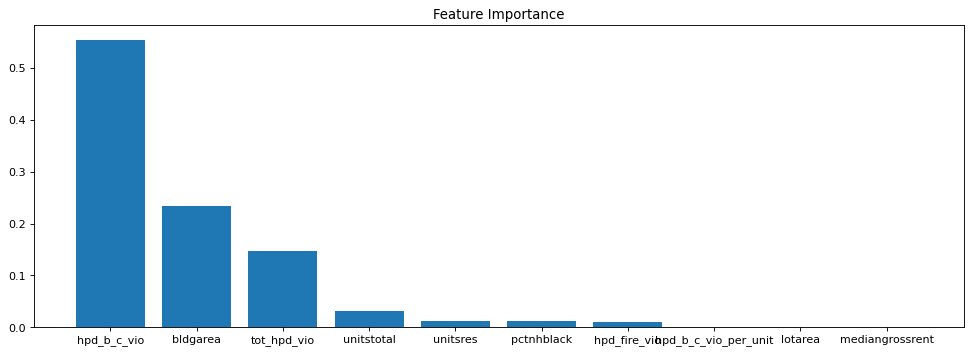

In [29]:
plt.figure(figsize=(15, 5), dpi=80)
plt.bar(Feature_importance.sort_values(by="importance",ascending=False).iloc[:10,0],
        Feature_importance.sort_values(by="importance",ascending=False).iloc[:10,1])
plt.title("Feature Importance");
plt.savefig(os.join(plots, 'feature_importance_bbl.png'))

## Random Forests

In [95]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=30, n_jobs=-1,max_leaf_nodes=10)
rf.fit(X_train, y_train)
pred=rf.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test,pred))

0.9738914787772018


In [31]:
param_grid = {'max_depth':range(1,50)}
rf = RandomForestClassifier(n_jobs=-1, n_estimators = 30)
gs = GridSearchCV(rf, param_grid=param_grid, scoring='roc_auc')
rs = gs.fit(X_train,y_train)
pred=rs.predict_proba(X_test)[:,1]
print(rs.best_params_)
print(roc_auc_score(np.array(y_test),pred))

{'max_depth': 9}
0.9773821705038671


In [34]:
rf = RandomForestClassifier(n_estimators=30, n_jobs=-1, max_depth = rs.best_params_['max_depth'])
rf.fit(X_train, y_train)
pred=rf.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test,pred))

0.9769670904269615


In [35]:
## look at precision and recall rates
precision_recall_fscore_support(y_test, (pred > 0.5))

(array([0.99663605, 0.75      ]),
 array([0.99998251, 0.01530612]),
 array([0.99830648, 0.03      ]),
 array([228724,    784], dtype=int64))

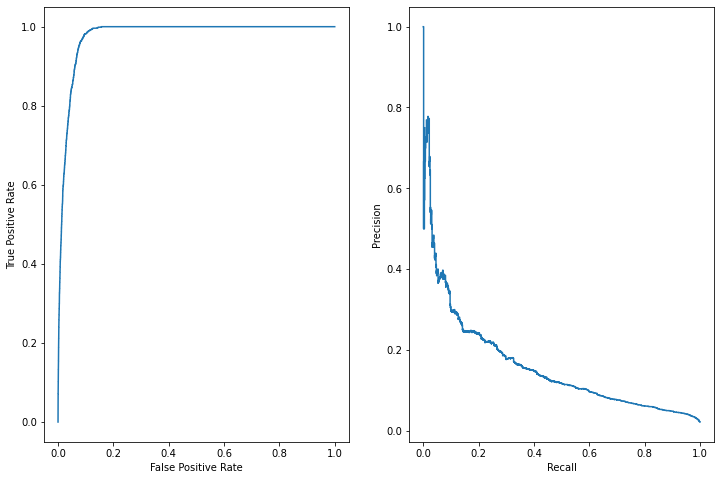

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

fpr, tpr, _ = roc_curve(y_test, pred, pos_label=1)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax1)

prec, recall, _ = precision_recall_curve(y_test, pred, pos_label= 1)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax2)

plt.show()
fig.savefig(os.join(plots, 'auc_precision_recall2.png'))

### CMM and other ensembles

In [19]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=30, random_state = 99, max_depth = 9) #rs.best_params_['max_depth'])
rf.fit(X_train,y_train)

# randomly generate a sample of xs
X_rand= pd.DataFrame({x:X_train[x].sample(n = round(0.25*X_train.shape[0])).reset_index(drop = True) for x in X_train.columns})
y_rand= rf.predict(X_rand)

In [20]:
# create the cmm training datasets
X_train_cmm= pd.concat([X_rand, X_train], axis = 0, ignore_index = True)
y_train_cmm= pd.concat([pd.DataFrame(y_rand), y_train], axis = 0, ignore_index = True)

In [39]:
param_grid = {'max_depth':range(1,30)}
dt=DecisionTreeClassifier()
gr=GridSearchCV(dt,param_grid=param_grid, scoring='roc_auc')
rs=gr.fit(X_train_cmm,y_train_cmm)
print(rs.best_params_)
print(roc_auc_score(np.array(y_test),rs.predict_proba(X_test)[:,1]))

{'max_depth': 4}
0.9750049431290327


In [22]:
# predict_proba predicts the probability of each class rather than just the most likely class
pred=rf.predict_proba(X_test)[:,1] # predicted probability of y = 1

print("ROC AUC:", roc_auc_score(np.array(y_test),pred))
## look at precision and recall rates
pr= precision_recall_fscore_support(y_test, pred > 0.5)
print("Precision:", pr[0][1])
print("Recall:", pr[1][1])

C:\Users\Jennah\AppData\Local\Temp/ipykernel_6980/3375257076.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train_cmm, y_train_cmm)


ROC AUC: 0.9759912936686191
Precision: 0.0
Recall: 0.0


C:\Users\Jennah\anaconda3\envs\geo_env\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
dt = DecisionTreeClassifier(max_depth= 4) #rs.best_params_['max_depth'])
dt.fit(X_train_cmm, y_train_cmm)

Feature_importance=pd.DataFrame([list(X_train_cmm.columns),list(dt.feature_importances_)]).T
Feature_importance.columns=["variables","importance"]

# list the top 10 most important features in order
ft2= Feature_importance.sort_values(by="importance",ascending=False)
#ft2.to_csv(os.join(interm, 'feature_importance_bbl2.csv'))
ft2.loc[ft2['importance']>0]

,variables,importance
15,hpd_b_c_vio,0.518463
1,bldgarea,0.317625
13,tot_hpd_vio,0.068446
14,hpd_fire_vio,0.033615
64,pctnhblack,0.027411
4,unitsres,0.021624
9,yearbuilt,0.010022
5,unitstotal,0.002795


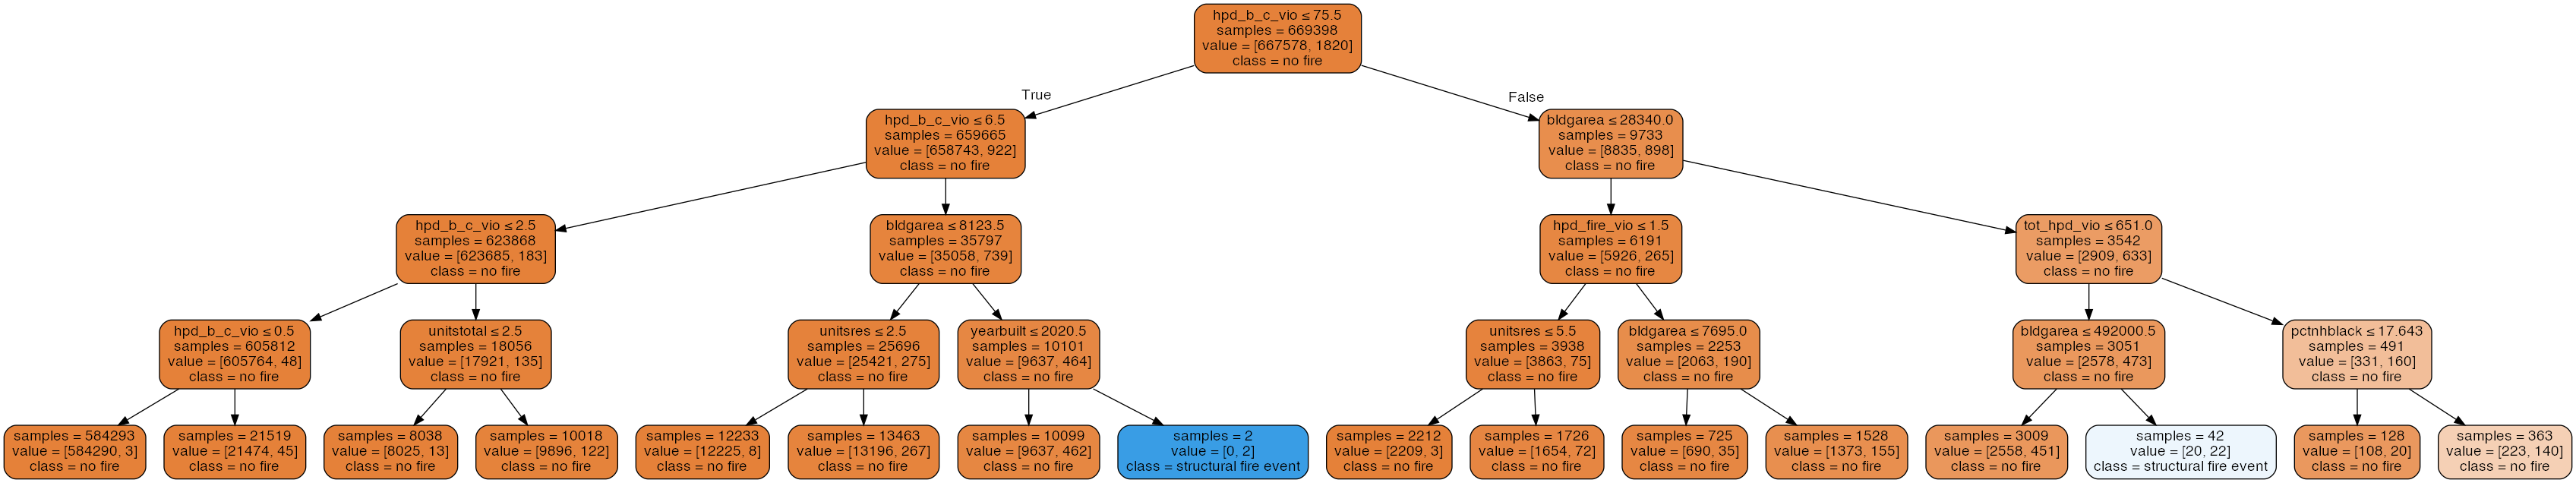

In [68]:
thestring = tree.export_graphviz(dt, out_file=None,  
                         feature_names=X_train.columns.values, 
                         class_names=['no fire','structural fire event'],  
                         filled=True, rounded=True,  
                         special_characters=True,impurity=False).replace(" ;\n}", " ;}")
graph = pydotplus.graph_from_dot_data(thestring);
graph.write_png(os.join(plots,'num_fire_ev_bbl_cmm.png'))
Image(graph.create_png())

## (2) Bayes Nets

In [13]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import K2Score, BicScore, BDeuScore
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator
import matplotlib.pyplot as plt

In [47]:
impt_vars= ["vacate_ind"] + ['hpd_b_c_vio', 'bldgarea', 'unitsres', 'pctnhblack', 'pcthispanic',
                            'hpd_fire_vio', 'holc_D', 'NB', 'AL', 'popdens', 'medianhhincome', 'pct65plus',
                            'pctownerocch', 'pctrentocch', 'crowdingrenter'] #ft.loc[ft['importance']>0, "variables"].tolist()
impt_vars

['vacate_ind',
 'hpd_b_c_vio',
 'bldgarea',
 'unitsres',
 'pctnhblack',
 'pcthispanic',
 'hpd_fire_vio',
 'holc_D',
 'NB',
 'AL',
 'popdens',
 'medianhhincome',
 'pct65plus',
 'pctownerocch',
 'pctrentocch',
 'crowdingrenter']

vacate_ind
hpd_b_c_vio


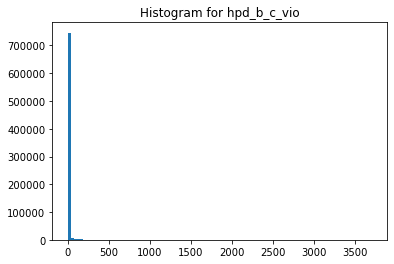

None
bldgarea


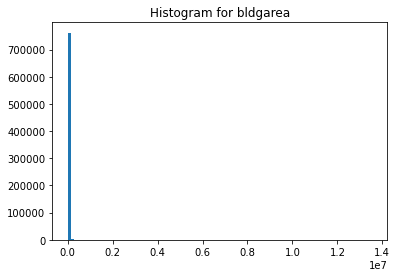

None
unitsres


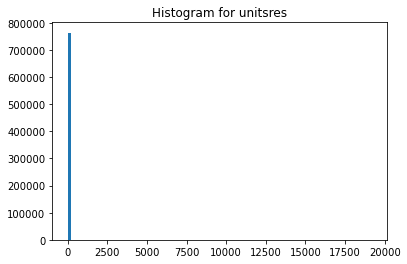

None
pctnhblack


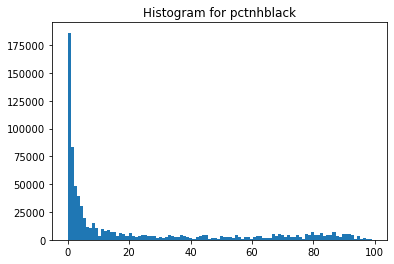

None
pcthispanic


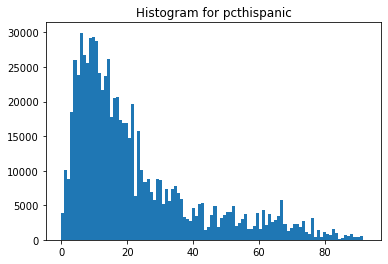

None
hpd_fire_vio


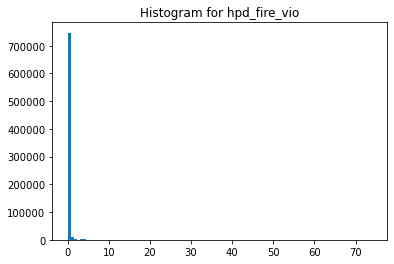

None
holc_D
NB


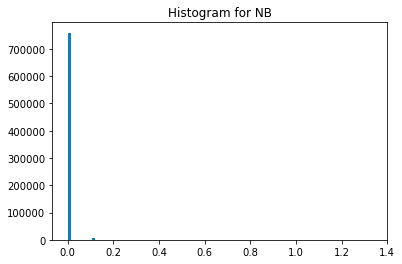

None
AL


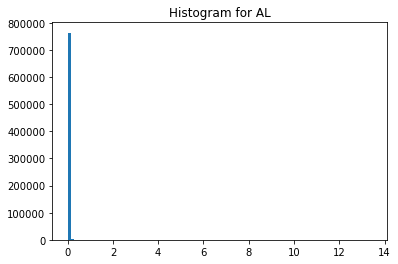

None
popdens


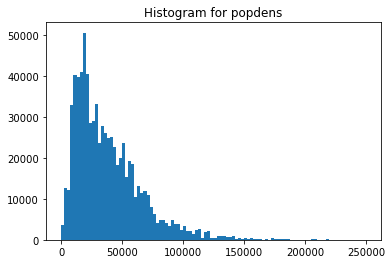

None
medianhhincome


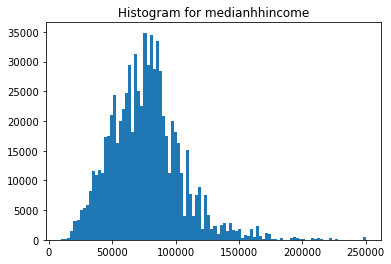

None
pct65plus


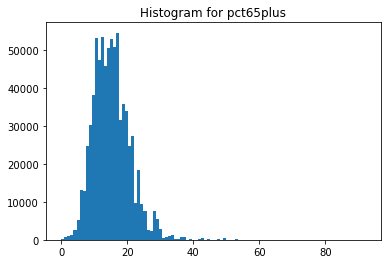

None
pctownerocch


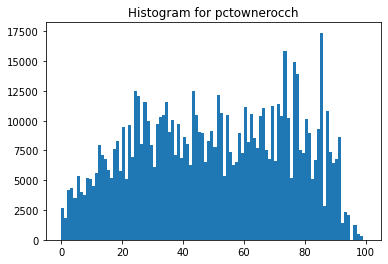

None
pctrentocch


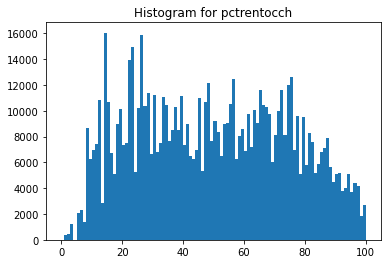

None
crowdingrenter


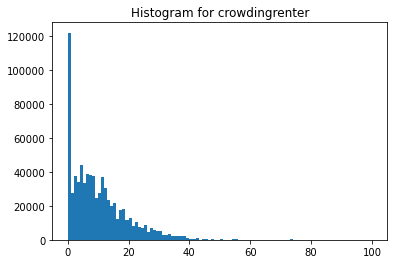

None


In [49]:
df_bbl_disc= df_bbl.loc[:, impt_vars].copy()
# need to discretize the data, also look at distributions
for i in impt_vars:
    print(i)
    if len(df_bbl_disc.loc[:, i].unique()) > 5:
        plt.hist(df_bbl_disc.loc[:, i], bins = 100);
        plt.title("Histogram for {}".format(i))
        print(plt.show())
        df_bbl_disc.loc[:, i] = pd.qcut(df_bbl_disc.loc[:, i], q=4, labels=False, duplicates = 'drop')

In [50]:
# create test train split for testing DAG
train, test = train_test_split(df_bbl_disc.loc[:, impt_vars], test_size=0.3, random_state=999)

In [51]:
# use hill climb search with BIC score, as in hw
hc = HillClimbSearch(train)
best_model = hc.estimate(scoring_method=BicScore(train))
print("\nDAG model edges:")
print(best_model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]


DAG model edges:
[('bldgarea', 'unitsres'), ('bldgarea', 'popdens'), ('bldgarea', 'pctnhblack'), ('bldgarea', 'pctrentocch'), ('bldgarea', 'pct65plus'), ('bldgarea', 'holc_D'), ('bldgarea', 'vacate_ind'), ('unitsres', 'pctrentocch'), ('unitsres', 'pct65plus'), ('unitsres', 'pctnhblack'), ('unitsres', 'vacate_ind'), ('unitsres', 'holc_D'), ('pctnhblack', 'pcthispanic'), ('pctnhblack', 'crowdingrenter'), ('pctnhblack', 'medianhhincome'), ('pctnhblack', 'popdens'), ('pctnhblack', 'holc_D'), ('pctnhblack', 'pctownerocch'), ('holc_D', 'medianhhincome'), ('holc_D', 'crowdingrenter'), ('holc_D', 'popdens'), ('popdens', 'pcthispanic'), ('popdens', 'crowdingrenter'), ('popdens', 'medianhhincome'), ('medianhhincome', 'pcthispanic'), ('pct65plus', 'pcthispanic'), ('pct65plus', 'crowdingrenter'), ('pct65plus', 'holc_D'), ('pct65plus', 'medianhhincome'), ('pct65plus', 'popdens'), ('pct65plus', 'pctnhblack'), ('pct65plus', 'pctownerocch'), ('pctownerocch', 'medianhhincome'), ('pctownerocch', 'pcthi

In [52]:
print("DAG model nodes:")
print(best_model.nodes())

DAG model nodes:
['vacate_ind', 'hpd_b_c_vio', 'bldgarea', 'unitsres', 'pctnhblack', 'pcthispanic', 'hpd_fire_vio', 'holc_D', 'NB', 'AL', 'popdens', 'medianhhincome', 'pct65plus', 'pctownerocch', 'pctrentocch', 'crowdingrenter']


In [53]:
# look at the CPD for the model
model = BayesianNetwork(best_model.edges())
model.fit(train.loc[:, impt_vars], estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=10)
for cpd in model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)
for n in model.nodes():
    print(model.local_independencies(n))

CPD of bldgarea:
+-------------+----------+
| bldgarea(0) | 0.250485 |
+-------------+----------+
| bldgarea(1) | 0.250303 |
+-------------+----------+
| bldgarea(2) | 0.249062 |
+-------------+----------+
| bldgarea(3) | 0.25015  |
+-------------+----------+
CPD of unitsres:
+-------------+----------------------+---------------------+---------------------+---------------------+
| bldgarea    | bldgarea(0)          | bldgarea(1)         | bldgarea(2)         | bldgarea(3)         |
+-------------+----------------------+---------------------+---------------------+---------------------+
| unitsres(0) | 0.8577198952847055   | 0.5186101133081427  | 0.21735599048829343 | 0.10541631675531088 |
+-------------+----------------------+---------------------+---------------------+---------------------+
| unitsres(1) | 0.1378904614405932   | 0.4496031790437753  | 0.5990338345347923  | 0.22424061459985692 |
+-------------+----------------------+---------------------+---------------------+-----------

+----------------+-------------------+-----+-------------------+-------------------+
| crowdingrenter | crowdingrenter(0) | ... | crowdingrenter(3) | crowdingrenter(3) |
+----------------+-------------------+-----+-------------------+-------------------+
| medianhhincome | medianhhincome(0) | ... | medianhhincome(3) | medianhhincome(3) |
+----------------+-------------------+-----+-------------------+-------------------+
| pct65plus      | pct65plus(0)      | ... | pct65plus(3)      | pct65plus(3)      |
+----------------+-------------------+-----+-------------------+-------------------+
| pctnhblack     | pctnhblack(0)     | ... | pctnhblack(3)     | pctnhblack(3)     |
+----------------+-------------------+-----+-------------------+-------------------+
| pctownerocch   | pctownerocch(0)   | ... | pctownerocch(3)   | pctownerocch(3)   |
+----------------+-------------------+-----+-------------------+-------------------+
| popdens        | popdens(0)        | ... | popdens(2)        | 

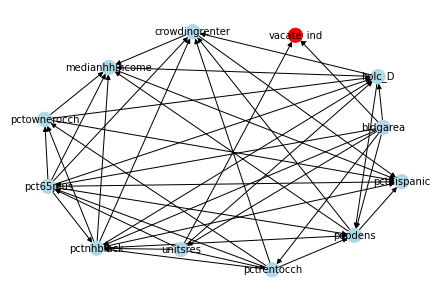

<Figure size 864x720 with 0 Axes>

In [54]:
import networkx as nx
import pylab as plt
fig = plt.gcf()

values = ['red' if n in ['vacate_ind'] else 'lightblue' for n in model.nodes()]
# use networkx to draw DAG
nx.draw(model, node_color=values, with_labels=True, font_color='black', node_size=200,font_size=10)

plt.figure(figsize = (12,10))
fig.savefig('dag_bbl.png')

In [55]:
pred = model.predict(test.loc[:, ['popdens']],
                    stochastic = True)
print(pred)

  0%|          | 0/4 [00:00<?, ?it/s]

        holc_D  bldgarea  pct65plus  pctnhblack  pctownerocch  unitsres  \
596255     0.0         2          1           0             2         0   
695748     0.0         1          3           0             3         0   
701775     0.0         1          0           2             0         0   
222295     0.0         0          0           3             2         0   
79883      0.0         0          2           1             0         0   
...        ...       ...        ...         ...           ...       ...   
708711     0.0         2          3           0             3         0   
577957     0.0         1          0           1             1         1   
667376     0.0         1          0           2             2         0   
400735     1.0         3          0           2             0         2   
685689     0.0         0          3           1             2         0   

        pctrentocch  crowdingrenter  medianhhincome  vacate_ind  pcthispanic  
596255            1 

In [56]:
# calc out of sample accuracy
print("\nOS accuracy for vacate orders")
print((pred['vacate_ind'].reset_index(drop = True) == test['vacate_ind'].reset_index(drop = True)).mean())

print("\nOS precision and recall for vacate orders")
print(precision_recall_fscore_support(np.asarray(test['vacate_ind']), 
                                      np.asarray(pred['vacate_ind'])))


OS accuracy for vacate orders
0.9932856371019747

OS precision and recall for vacate orders
(array([0.99659006, 0.00522876]), array([0.99667285, 0.00510204]), array([0.99663145, 0.00516462]), array([228724,    784], dtype=int64))


# Anomaly Detection

## Isolation forests

In [57]:
from sklearn.ensemble import IsolationForest

# generate outliers
X_outliers= X.loc[X.loc[y==1].index, :]
X_reg= X.loc[X.loc[y==0].index, :]
# generate test and train data
X_train, X_test= train_test_split(X_reg, test_size=0.3, random_state=999)

# fit the model
if_clf = IsolationForest(max_samples=100, random_state=99)
if_clf.fit(X_train)
y_pred_train = if_clf.predict(X_train)
y_pred_test = if_clf.predict(X_test)
y_pred_outliers = if_clf.predict(X_outliers)

In [58]:
print("Percent training classified as inliers:", np.mean(y_pred_train==1))
print("Percent test data classified as inliers:", np.mean(y_pred_test==1))
print("Percent outliers classified as inliers:", np.mean(y_pred_outliers==1))

Percent training classified as inliers: 0.9173123225812496
Percent test data classified as inliers: 0.9169621426416645
Percent outliers classified as inliers: 0.2411674347158218


In [69]:
# low precision and recall (esp. compared to random forest)
print("\nOS precision and recall for isolation tree")
precision_recall_fscore_support(np.append(y_pred_test, y_pred_outliers),
                                      np.append(np.repeat(-1, len(y_pred_test)), np.repeat(1, len(y_pred_outliers))))


OS precision and recall for isolation tree


(array([0.08303786, 0.24116743]),
 array([0.90576565, 0.00298533]),
 array([0.15212899, 0.00589766]),
 array([ 20969, 210362], dtype=int64))